# 004_Deep_Metric_Learning
MNISTのデータを使って自分でNNを作成してL2-softmaxでやってみる

# NMISTのダウンロード

In [1]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST

from fastprogress import progress_bar


# # データセットのダウンロード
# mnist_data = MNIST('~/tmp/mnist', train=True, download=True, transform=transforms.ToTensor())
# data_loader = DataLoader(mnist_data,
#                          batch_size=4,
#                          shuffle=False
#                          )

In [2]:
import glob
import cv2

In [3]:
train_png_data_path = 'data/images/train/*/*'
valid_png_data_path = 'data/images/valid/*/*'

In [4]:
train_png_data_path_list = sorted(glob.glob(train_png_data_path))
valid_png_data_path_list = sorted(glob.glob(valid_png_data_path))

In [5]:
train_im_list = [(cv2.imread(i,0), i.split('/')[3]) for i in train_png_data_path_list]
valid_im_list = [(cv2.imread(i,0), i.split('/')[3]) for i in valid_png_data_path_list]

In [6]:
# Mydatasetの作成
import torch
class MyDataset(Dataset):

    def __init__(self, data_set, target, transform=None):
        self.transform = transform
        self.data = []
        self.target = []
        for x, i in data_set:
            if i == str(target):
                self.data.append(x)
                self.target.append(int(i))
            
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_target =  self.target[idx]

        if self.transform:
            out_data = self.transform(out_data)
#             out_target = self.transform(out_target)

        return out_data, out_target

In [7]:
train_norm_data_set = MyDataset(train_im_list, 4, transform=transforms.ToTensor())
valid_norm_data_set = MyDataset(valid_im_list, 4, transform=transforms.ToTensor())
valid_anom1_data_set = MyDataset(valid_im_list, 9, transform=transforms.ToTensor())
valid_anom2_data_set = MyDataset(valid_im_list, 5, transform=transforms.ToTensor())

In [8]:
# data loader の作成
train_norm_dataloader = DataLoader(train_norm_data_set, batch_size=10, shuffle=True)
valid_norm_dataloader = DataLoader(valid_norm_data_set, batch_size=10, shuffle=False)
valid_anom1_dataloader = DataLoader(valid_anom1_data_set, batch_size=10, shuffle=False)
valid_anom2_dataloader = DataLoader(valid_anom2_data_set, batch_size=10, shuffle=False)

# モデルの定義

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 100)
        self.ac1 = nn.ReLU() 
        self.fc2 = nn.Linear(100, 50)
        self.ac2 = nn.ReLU()
        self.fc3 = nn.Linear(50, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.ac1(self.fc1(x))
        x = self.ac2(self.fc2(x))
        x = self.fc3(x)
        
        return x

# コスト関数と最適化手法の定義

In [10]:
net=Net()

In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),
                      lr = 0.001
                     )

In [12]:
net.train()
loss_list_net =[]
num_epochs=50

for epoch in progress_bar(range(num_epochs)):
    losses_net = []
    
    for data in train_norm_dataloader:
        x, target = data
#         x, target = x.to(device), target.to(device)
        optimizer.zero_grad()
        xhat = net(x.float())
        loss = criterion(xhat.float(), target.long())
        loss.backward()
        optimizer.step()
        
#         losses_net.append(loss.cpu().detach().numpy())
        losses_net.append(loss.detach().numpy())
        
    print('epoch [{}/{}], loss: {:.4f}'.format(epoch +1, num_epochs, np.average(losses_net)))
    loss_list_net.append(np.average(losses_net))
        
        

epoch [1/50], loss: 1.3569
epoch [2/50], loss: 0.0683
epoch [3/50], loss: 0.0182
epoch [4/50], loss: 0.0100
epoch [5/50], loss: 0.0067
epoch [6/50], loss: 0.0050
epoch [7/50], loss: 0.0040
epoch [8/50], loss: 0.0033
epoch [9/50], loss: 0.0028
epoch [10/50], loss: 0.0024
epoch [11/50], loss: 0.0021
epoch [12/50], loss: 0.0019
epoch [13/50], loss: 0.0017
epoch [14/50], loss: 0.0016
epoch [15/50], loss: 0.0014
epoch [16/50], loss: 0.0013
epoch [17/50], loss: 0.0012
epoch [18/50], loss: 0.0011
epoch [19/50], loss: 0.0011
epoch [20/50], loss: 0.0010
epoch [21/50], loss: 0.0010
epoch [22/50], loss: 0.0009
epoch [23/50], loss: 0.0009
epoch [24/50], loss: 0.0008
epoch [25/50], loss: 0.0008
epoch [26/50], loss: 0.0007
epoch [27/50], loss: 0.0007
epoch [28/50], loss: 0.0007
epoch [29/50], loss: 0.0006
epoch [30/50], loss: 0.0006
epoch [31/50], loss: 0.0006
epoch [32/50], loss: 0.0006
epoch [33/50], loss: 0.0006
epoch [34/50], loss: 0.0005
epoch [35/50], loss: 0.0005
epoch [36/50], loss: 0.0005
e

In [13]:
import matplotlib.pyplot as plt

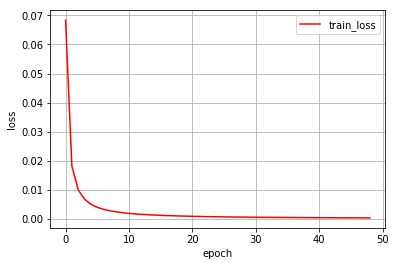

In [14]:
plt.figure()
plt.plot(range(epoch), loss_list_net[1:], 'r-', label = 'train_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

In [15]:
import sys

In [27]:
# テスト開始
net.eval()

with torch.no_grad():
    # 正常データテスト
    losses_norm = []
    hidden_layer_norm = []
    count=0
    for data in progress_bar(valid_norm_dataloader):
        x, target = data
        xhat = net(x.float())
        loss_norm = criterion(xhat.float(), target.long())
        losses_norm.append(loss_norm.detach().numpy())
        hidden_layer_norm.append(xhat.detach().numpy())
        count += 1
        
net.eval()
with torch.no_grad():
    # 異常データテスト1
    losses_anom1 = []
    hidden_layer_anom1 = []
    count=0
    for data in progress_bar(valid_anom1_dataloader):
        x, target = data
        xhat = net(x.float())
        loss_anom = criterion(xhat.float(), target.long())
        losses_anom1.append(loss_anom.detach().numpy())
        hidden_layer_anom1.append(xhat.detach().numpy())
        count += 1
net.eval()
with torch.no_grad():
    # 異常データテスト2
    losses_anom2 = []
    hidden_layer_anom2 = []
    count=0
    for data in progress_bar(valid_anom2_dataloader):
        x, target = data
        xhat = net(x.float())
        loss_anom = criterion(xhat.float(), target.long())
        losses_anom2.append(loss_anom.detach().numpy())
        hidden_layer_anom2.append(xhat.detach().numpy())
        count += 1


In [28]:
hidden_layer_norm[0]

array([[-1.3438853 , -1.4761821 , -0.74588996, -1.538428  ,  9.192066  ,
        -1.4155595 , -1.3330362 , -0.9634459 , -1.4529384 , -1.4989836 ],
       [-1.4436777 , -1.5723776 , -0.74929017, -1.6109387 ,  9.646583  ,
        -1.5152527 , -1.4171641 , -1.01677   , -1.6095153 , -1.5578909 ],
       [-1.3969641 , -1.5781336 , -0.75878125, -1.6000477 ,  9.594581  ,
        -1.5167325 , -1.3889251 , -1.0137098 , -1.6082046 , -1.5636823 ],
       [-1.0283726 , -1.104477  , -0.564806  , -1.195244  ,  7.0428076 ,
        -1.1041052 , -0.98801726, -0.74867254, -1.1089537 , -1.1042714 ],
       [-1.7338183 , -1.9218117 , -0.9901545 , -1.921266  , 11.799468  ,
        -1.8440516 , -1.7475337 , -1.2122535 , -1.9620354 , -1.9497175 ],
       [-1.0565737 , -1.1013961 , -0.57168764, -1.1560715 ,  7.236267  ,
        -1.1285156 , -1.0120697 , -0.7768004 , -1.1374524 , -1.1394335 ],
       [-1.8633201 , -2.0769062 , -1.0599424 , -2.063782  , 12.617508  ,
        -1.9638872 , -1.8292131 , -1.2421234 

In [29]:
hidden_layer_anom1[0]

array([[-1.3728826 , -1.520922  , -0.8051219 , -1.5721427 ,  9.396451  ,
        -1.4555436 , -1.3343675 , -0.9625963 , -1.5659624 , -1.5305151 ],
       [-1.9794459 , -2.2590628 , -1.1225978 , -2.2235572 , 13.533368  ,
        -2.109183  , -2.0186641 , -1.4012563 , -2.2963858 , -2.257194  ],
       [-1.7791787 , -1.9902846 , -1.0104281 , -1.9686972 , 12.127657  ,
        -1.9034145 , -1.7735279 , -1.2498208 , -2.070939  , -2.0016582 ],
       [-1.5872293 , -1.7665839 , -0.8835391 , -1.7697315 , 10.906247  ,
        -1.7009734 , -1.5857449 , -1.1141428 , -1.794975  , -1.7854491 ],
       [-1.8478123 , -2.0697021 , -1.0571967 , -2.0718708 , 12.486885  ,
        -1.9609153 , -1.827156  , -1.3141266 , -2.1131983 , -2.0527942 ],
       [-1.8314497 , -2.0674913 , -1.0656418 , -2.0570033 , 12.563356  ,
        -1.9432763 , -1.832397  , -1.2812948 , -2.1226363 , -2.0855186 ],
       [-1.0309275 , -1.1562831 , -0.5276395 , -1.1898696 ,  7.2726073 ,
        -1.1453958 , -1.045598  , -0.77584285

In [30]:
hidden_layer_anom2[0]

array([[-1.6112193 , -1.7753836 , -0.9192673 , -1.8034923 , 11.064114  ,
        -1.6687211 , -1.549166  , -1.1170274 , -1.8134764 , -1.7985429 ],
       [-0.9150911 , -0.9212118 , -0.41370288, -1.0526985 ,  6.0436172 ,
        -0.97345114, -0.8417353 , -0.6335583 , -1.012353  , -0.91108775],
       [-1.1755304 , -1.3077701 , -0.6419844 , -1.3535377 ,  8.162203  ,
        -1.2669643 , -1.148371  , -0.86824   , -1.3184962 , -1.273341  ],
       [-1.1416508 , -1.1977077 , -0.6084135 , -1.2798264 ,  7.649331  ,
        -1.1847984 , -1.0724003 , -0.81147724, -1.2371671 , -1.1914235 ],
       [-1.4592059 , -1.637043  , -0.8207209 , -1.6692501 ,  9.951758  ,
        -1.5707451 , -1.4307725 , -1.0842117 , -1.6597341 , -1.6161176 ],
       [-0.81919736, -0.8462841 , -0.3636653 , -0.96711296,  5.566349  ,
        -0.9209138 , -0.7579512 , -0.6131657 , -0.8933915 , -0.8142935 ],
       [-0.72343093, -0.78362644, -0.33315444, -0.86508703,  5.019664  ,
        -0.82824576, -0.6751485 , -0.5829979 

In [31]:
from scipy.sparse.csgraph import connected_components

In [61]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import axes3d
#%matplotlib notebook

def show_3D_tSNE(latent_vecs, target, title='3D t-SNE viz'):
    latent_vecs = latent_vecs
    tsne = TSNE(n_components=3, random_state=0).fit_transform(latent_vecs)
    fig = plt.figure(figsize=(13,10))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter3D(tsne[:, 0], tsne[:, 1], tsne[:, 2], c=target, cmap='jet')
    ax.set_title(title)
    plt.colorbar(scatter)
    plt.show()

In [50]:
norm_hidden = list(itertools.chain.from_iterable(hidden_layer_norm))
anom1_hidden = list(itertools.chain.from_iterable(hidden_layer_anom1))
anom2_hidden = list(itertools.chain.from_iterable(hidden_layer_anom2))

In [64]:
norm_target = [0] * len(norm_hidden)
anom1_target = [1] * len(anom1_hidden)
anom2_target = [2] * len(anom2_hidden)


In [65]:
hidden_list = norm_hidden+anom1_hidden+anom2_hidden
target_list = norm_target+anom1_target+anom2_target 

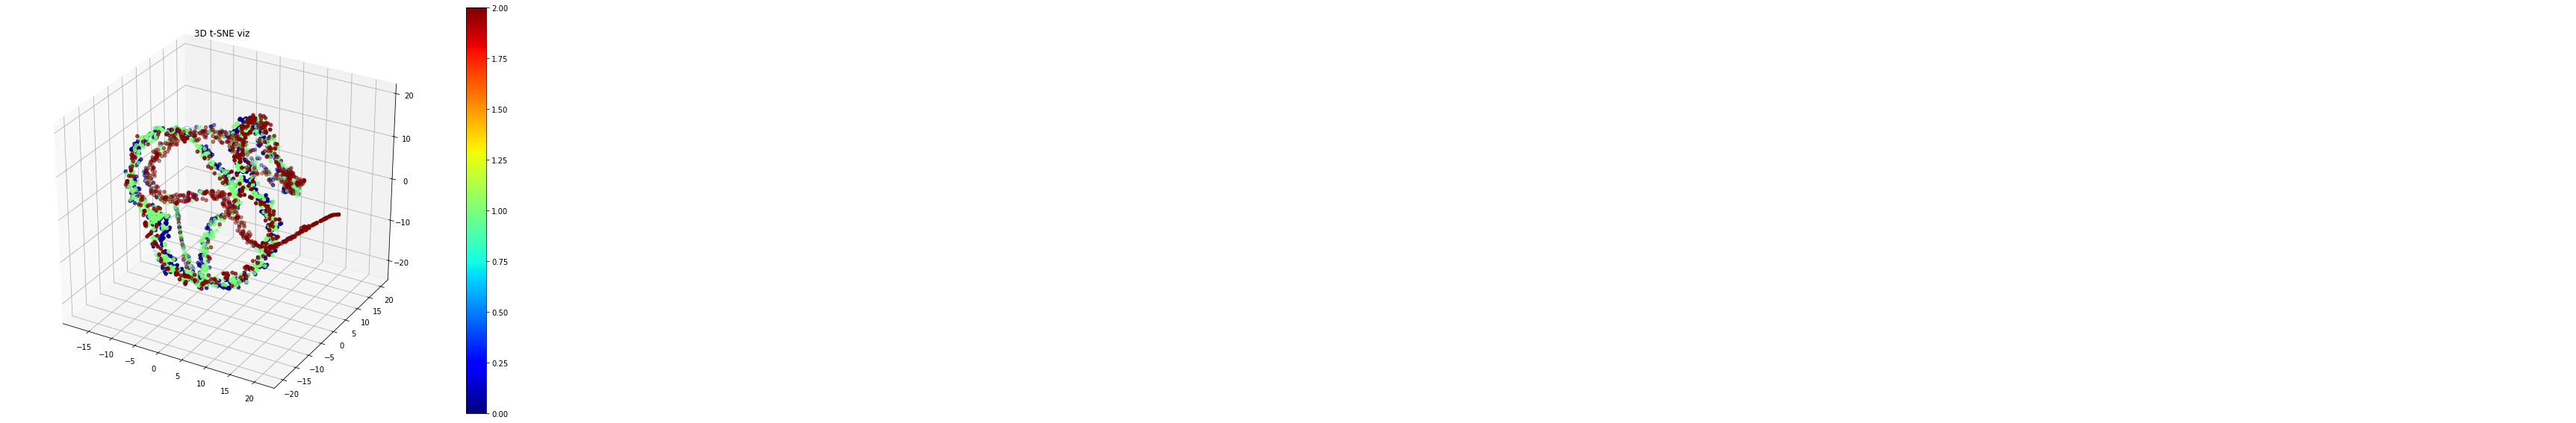

In [67]:
show_3D_tSNE(hidden_list, target_list)

In [68]:
def show_2D_tSNE(latent_vecs, target, title='t-SNE viz'):
    latent_vecs = latent_vecs
    latent_vecs_reduced = TSNE(n_components=2, random_state=0).fit_transform(latent_vecs)
    plt.scatter(latent_vecs_reduced[:, 0], latent_vecs_reduced[:, 1],
                c=target, cmap='jet')
    plt.colorbar()
    plt.show()


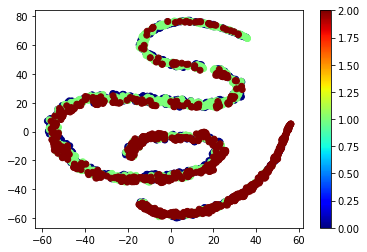

In [69]:
show_2D_tSNE(hidden_list, target_list)